Data from Kaggle:

https://www.kaggle.com/antfarol/car-sale-advertisements

https://www.kaggle.com/satadru5/car-sale-prediction

# 1. Importing the relevant libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

# 2. Common function

In [13]:
def Predictive_Model(num_df, cat_df, target):
    
    # scaling features for numerical vars
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(num_df)
    input_df = scaler.transform(num_df)
    input_df = pd.DataFrame(input_df, columns = num_df.columns)
    
    # merge num_df and dummy cat_df
    if(cat_df.shape[0] > 0):
        input_df = pd.concat([input_df,cat_df],axis=1)
        
    # train test split
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(input_df, target, test_size=0.2, random_state=365)
    
    # built model   
    model = Sequential()
    model.add(Dense(20, input_dim=input_df.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    model.summary()
    history = model.fit(X_train, y_train, epochs=100, batch_size=50,  verbose=1, validation_split=0.2)
    model.fit(X_train, y_train)
    

In [3]:
# Distribution plot

def analyse_continuous(df,var,target,title):
    df = df.copy()
    df[var] = df[var].fillna(df[var].median())
    plt.figure(figsize=(21,6))
    plt.subplot(131)
    sns.boxplot(x=df[var])
    plt.title(title)
    plt.subplot(132)
    sns.distplot(df[var],hist=True, kde=True,kde_kws={'shade': True, 'linewidth': 3})
    plt.title(title)
    plt.subplot(133)
    plt.scatter(df[var],df[target])
    plt.title(title)
    # skewness and kurtosis
    print('Skewness: %f' % df[var].skew())
    print('Kurtosis: %f' % df[var].kurt())
    plt.title(title)
    plt.show()

# 3. Loading the raw data

In [4]:
raw_data = pd.read_csv('CarSale.csv')
raw_data.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4


This is a list of second hand cars with the respective price of body, mileage, engine volume, engine type, production model and information about the time when they were registered. What we would like to do is predict the price of a used car depending on its specifications. 

    + The first potential aggressor is brand as it is well-known that a BMW is generally more expensive than a Toyota. 
    + The second relevant variable is mileage since the more a car is driven the cheaper it should be. 
    + Third, the engine volume, sports cars have larger engines and economy cars have smaller engines
    + The final variable is year of production, the older the car, the cheaper it is with the exception of vintage vehicles
    + The rest are categorical variables which we'll deal with on a case by case basis

In [5]:
# Let's check the descriptives without 'Model'
data = raw_data.copy()
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,4345,7,Volkswagen,936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,4173,NaN,NaN,NaN,19418.7,25584.2,600,6999,11500,21700,300000
Body,4345,6,sedan,1649,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,4345,NaN,NaN,NaN,161.237,105.706,0,86,155,230,980
EngineV,4195,NaN,NaN,NaN,2.79073,5.06644,0.6,1.8,2.2,3,99.99
Engine Type,4345,4,Diesel,2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,4345,2,yes,3947,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,4345,NaN,NaN,NaN,2006.55,6.7191,1969,2003,2008,2012,2016
Model,4345,312,E-Class,199,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 4. Dealing with Missing data

### Approach 1: Removing rows with missing values

A rule of thumb is that if you are removing less than 5 percent of observations, you are free to just remove all observations that have missing values. In this case they are less than that, so we are safe

In [6]:
# Lest's simply drop all missing values
# This is not always recommended, however, when we remove less than 5% of the data, it is okay
df_missing_data = data.copy()
data = data.dropna(axis=0)
data.reset_index(drop=True,inplace=True)
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,4025,7,Volkswagen,880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,4025,NaN,NaN,NaN,19552.3,25815.7,600,6999,11500,21900,300000
Body,4025,6,sedan,1534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,4025,NaN,NaN,NaN,163.572,103.395,0,90,158,230,980
EngineV,4025,NaN,NaN,NaN,2.76459,4.93594,0.6,1.8,2.2,3,99.99
Engine Type,4025,4,Diesel,1861,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,4025,2,yes,3654,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,4025,NaN,NaN,NaN,2006.38,6.6956,1969,2003,2007,2012,2016
Model,4025,306,E-Class,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Approach 2: Replacing missing values with mean/median

### Approach 3: Adding a binary col to indicate there is missing value

# 5. ANN without Preprocessing data

In [14]:
num_df = data[['Mileage','EngineV','Year']]
cat_df = data[['Brand','Body','Engine Type','Registration','Model']]
cat_df = pd.get_dummies(cat_df, drop_first=True)
target = data['Price']

Predictive_Model(num_df, cat_df, target)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                6480      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 6,701
Trainable params: 6,701
Non-trainable params: 0
_________________________________________________________________
Train on 2576 samples, validate on 644 samples
Epoch 1/100
2576/2576 [==============================] - 0s 168us/sample - loss: 1133607653.2671 - mse: 1133607680.0000 - mae: 19885.8184 - val_loss: 1097058769.8882 - val_mse: 1097058816.0000 - val_mae: 19782.6895
Epoch 2/100
2576/2576 [==============================] - 0s 40us/sample - loss: 1133489358.7826 - mse: 1133489280.0000 -

Epoch 36/100
2576/2576 [==============================] - 0s 43us/sample - loss: 655268175.7578 - mse: 655268160.0000 - mae: 11068.2305 - val_loss: 612999974.3602 - val_mse: 612999872.0000 - val_mae: 10711.5020
Epoch 37/100
2576/2576 [==============================] - 0s 38us/sample - loss: 641786310.4472 - mse: 641786368.0000 - mae: 11035.6611 - val_loss: 599646018.5093 - val_mse: 599646080.0000 - val_mae: 10670.8203
Epoch 38/100
2576/2576 [==============================] - 0s 37us/sample - loss: 629248135.0932 - mse: 629248192.0000 - mae: 11022.3975 - val_loss: 587148325.3665 - val_mse: 587148288.0000 - val_mae: 10648.3389
Epoch 39/100
2576/2576 [==============================] - 0s 36us/sample - loss: 617561672.7950 - mse: 617561728.0000 - mae: 11019.2793 - val_loss: 575367201.8385 - val_mse: 575367232.0000 - val_mae: 10626.1436
Epoch 40/100
2576/2576 [==============================] - 0s 41us/sample - loss: 606753657.1677 - mse: 606753536.0000 - mae: 11048.4893 - val_loss: 56425893

Epoch 75/100
2576/2576 [==============================] - 0s 38us/sample - loss: 428842296.9193 - mse: 428842304.0000 - mae: 10401.2090 - val_loss: 388977913.3913 - val_mse: 388977888.0000 - val_mae: 9876.6543
Epoch 76/100
2576/2576 [==============================] - 0s 38us/sample - loss: 425772328.3416 - mse: 425772384.0000 - mae: 10367.7178 - val_loss: 385921126.3354 - val_mse: 385921120.0000 - val_mae: 9861.7021
Epoch 77/100
2576/2576 [==============================] - 0s 40us/sample - loss: 422771473.5528 - mse: 422771488.0000 - mae: 10345.0137 - val_loss: 383160360.8199 - val_mse: 383160384.0000 - val_mae: 9831.5283
Epoch 78/100
2576/2576 [==============================] - 0s 42us/sample - loss: 419879752.5280 - mse: 419879872.0000 - mae: 10336.5928 - val_loss: 380267222.0621 - val_mse: 380267232.0000 - val_mae: 9813.0283
Epoch 79/100
2576/2576 [==============================] - 0s 38us/sample - loss: 416880542.9006 - mse: 416880544.0000 - mae: 10288.8848 - val_loss: 377673377.96

=> Large number of inputs may cause overfitting problem

# 6. Preprocessing data

=> Preprocessing is an important step in Data Analysis which include many techniques to improve the accuracy of the predictive model through understanding data characteristics and preprocess data to fit model's ability

## 6.1. Numerical vars

In [15]:
target_var = 'Price'
num_vars = [var for var in data.columns if data[var].dtypes != 'O' and var != target_var]
target = data['Price']
num_df = data[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 11        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
Train on 2576 samples, validate on 644 samples
Epoch 1/100
2576/2576 [==============================] - 0s 164us/sample - loss: 1133628359.3043 - mse: 1133628416.0000 - mae: 19886.2363 - val_loss: 1097108179.9752 - val_mse: 1097108096.0000 - val_mae: 19783.6699
Epoch 2/100
2576/2576 [==============================] - 0s 33us/sample - loss: 1133596119.3540 - mse: 1133595904.0000 - mae

2576/2576 [==============================] - 0s 33us/sample - loss: 841097675.4472 - mse: 841097664.0000 - mae: 15190.2393 - val_loss: 797563203.5280 - val_mse: 797563200.0000 - val_mae: 15025.9365
Epoch 36/100
2576/2576 [==============================] - 0s 36us/sample - loss: 823671335.0311 - mse: 823671296.0000 - mae: 14889.8838 - val_loss: 780309042.4845 - val_mse: 780308992.0000 - val_mae: 14718.9473
Epoch 37/100
2576/2576 [==============================] - 0s 37us/sample - loss: 806373149.0683 - mse: 806373312.0000 - mae: 14595.4678 - val_loss: 762598079.3540 - val_mse: 762598080.0000 - val_mae: 14405.8164
Epoch 38/100
2576/2576 [==============================] - 0s 36us/sample - loss: 788870521.4907 - mse: 788870656.0000 - mae: 14302.6494 - val_loss: 744547160.5963 - val_mse: 744547136.0000 - val_mae: 14098.8154
Epoch 39/100
2576/2576 [==============================] - 0s 36us/sample - loss: 771640324.2733 - mse: 771640320.0000 - mae: 14015.2373 - val_loss: 727219434.2360 - val_

2576/2576 [==============================] - 0s 33us/sample - loss: 488288865.6584 - mse: 488288800.0000 - mae: 11982.0801 - val_loss: 431680937.1925 - val_mse: 431680960.0000 - val_mae: 11058.1152
Epoch 74/100
2576/2576 [==============================] - 0s 32us/sample - loss: 487641338.7516 - mse: 487641312.0000 - mae: 12014.9268 - val_loss: 430652367.2547 - val_mse: 430652384.0000 - val_mae: 11084.2285
Epoch 75/100
2576/2576 [==============================] - 0s 31us/sample - loss: 487027877.3602 - mse: 487027872.0000 - mae: 12054.7295 - val_loss: 429671585.4907 - val_mse: 429671616.0000 - val_mae: 11111.6758
Epoch 76/100
2576/2576 [==============================] - 0s 32us/sample - loss: 486577175.8385 - mse: 486577280.0000 - mae: 12089.3203 - val_loss: 428824106.5093 - val_mse: 428824128.0000 - val_mae: 11140.7148
Epoch 77/100
2576/2576 [==============================] - 0s 33us/sample - loss: 486099969.5963 - mse: 486100000.0000 - mae: 12118.0850 - val_loss: 428370675.5031 - val_

### Target variable: Price

#### Exploring the PDFs

Notice the minimum and maximum values with respect to the mean and the core tiles for each variable and examine them using the probability distribution functions. Price has a mean around nineteen thousand dollars, the minimum price is six hundred dollars twenty five, twenty five percent of price are under seven thousand dollars, 50 percent below eleven thousand five hundred dollars and seventy five percent are lower than twenty one thousand nine hundred dollars. **Yet the maximum price is three hundred thousand dollars**. Something strange is going on

A great step in the data exploration is to display the probability distribution function (PDF) of a variable. The PDF will show us how that variable is distributed. This makes it very easy to spot anomalies, such as outliers. The PDF is often thee basis on which we decide whether we want to transform a features

Outliers are observations that lie on abnormal distance from observations in the data, they will affect the regression dramatically in cost coefficients to be inflated (thoi phong) as the regression will try to place the line closer to those values. Outliers are a great issue for OLS, thus we must deal with them in some way. 

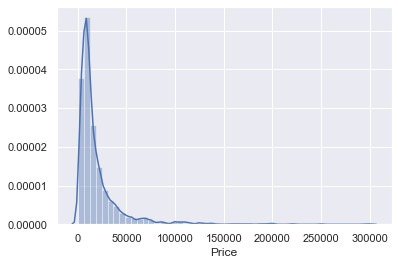

In [16]:
sns.distplot(data['Price'])

For optimal results, we would be looking for a normal distribution price however has an exponential one. This will surely be a problem for our regression. Obviously we have a few outliers in the price variable. 

Without diving too deep into the topic, we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples. Logic should also be applied. This is a dataset about used cars, therefore one can imagine how $300,000 is an excessive price

In [17]:
# Declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = data['Price'].quantile(0.99)
# Then we can create a new df, with the condition that all prices must be below the 99 percentile of 'Price'
data_1 = data[data['Price']<q]
data_1.reset_index(drop=True, inplace=True)
# In this way we have essentially remove the top 1% of the data about 'Price'
data_1.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Brand,3984,7,Volkswagen,880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,3984,NaN,NaN,NaN,17837.1,18976.3,600,6980,11400,21000,129222
Body,3984,6,sedan,1528,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,3984,NaN,NaN,NaN,165.116,102.766,0,93,160,230,980
EngineV,3984,NaN,NaN,NaN,2.74377,4.95606,0.6,1.8,2.2,3,99.99
Engine Type,3984,4,Diesel,1853,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Registration,3984,2,yes,3613,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Year,3984,NaN,NaN,NaN,2006.29,6.67274,1969,2002.75,2007,2011,2016
Model,3984,302,E-Class,188,NaN,NaN,NaN,NaN,NaN,NaN,NaN


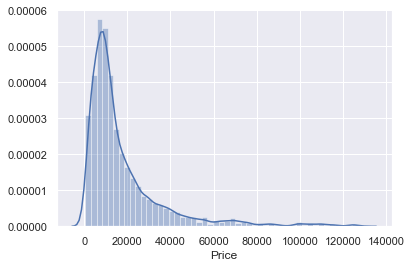

In [18]:
# We can check the PDF once again to ensure that the result is still distributed in the same way overall
# however, there are much fewer outliers
sns.distplot(data_1['Price'])

The data is still distributed in the same way but with less outliers. We can deal with it in the same way keeping only the data lower than the ninety ninth percentile

In [19]:
num_vars = [var for var in data.columns if data[var].dtypes != 'O' and var != target_var]
target = data_1['Price']
num_df = data_1[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
Train on 2549 samples, validate on 638 samples
Epoch 1/100
2549/2549 [==============================] - 1s 224us/sample - loss: 704639522.4229 - mse: 704639552.0000 - mae: 18149.6484 - val_loss: 628620394.1317 - val_mse: 628620416.0000 - val_mae: 17025.6777
Epoch 2/100
2549/2549 [==============================] - 0s 34us/sample - loss: 704615270.4653 - mse: 704615232.0000 - mae: 1814

2549/2549 [==============================] - 0s 36us/sample - loss: 498900711.8211 - mse: 498900640.0000 - mae: 14334.9971 - val_loss: 437603352.2257 - val_mse: 437603392.0000 - val_mae: 13175.1533
Epoch 37/100
2549/2549 [==============================] - 0s 33us/sample - loss: 486498022.3021 - mse: 486498080.0000 - mae: 14079.1904 - val_loss: 426681299.0596 - val_mse: 426681312.0000 - val_mae: 12927.5986
Epoch 38/100
2549/2549 [==============================] - 0s 31us/sample - loss: 474025659.5371 - mse: 474025760.0000 - mae: 13823.4980 - val_loss: 415601076.8652 - val_mse: 415601056.0000 - val_mae: 12680.4150
Epoch 39/100
2549/2549 [==============================] - 0s 32us/sample - loss: 461497533.4892 - mse: 461497472.0000 - mae: 13559.8086 - val_loss: 404421528.3260 - val_mse: 404421536.0000 - val_mae: 12431.2881
Epoch 40/100
2549/2549 [==============================] - 0s 32us/sample - loss: 448949510.2895 - mse: 448949568.0000 - mae: 13296.0332 - val_loss: 393374060.4389 - val_

Epoch 75/100
2549/2549 [==============================] - 0s 40us/sample - loss: 215024010.2691 - mse: 215024032.0000 - mae: 9830.2549 - val_loss: 209991717.8182 - val_mse: 209991712.0000 - val_mae: 10075.8232
Epoch 76/100
2549/2549 [==============================] - 0s 39us/sample - loss: 214383975.8148 - mse: 214383984.0000 - mae: 9848.4795 - val_loss: 209934456.1505 - val_mse: 209934464.0000 - val_mae: 10103.0332
Epoch 77/100
2549/2549 [==============================] - 0s 41us/sample - loss: 213834051.0443 - mse: 213834064.0000 - mae: 9865.2920 - val_loss: 209928477.5925 - val_mse: 209928480.0000 - val_mae: 10126.8379
Epoch 78/100
2549/2549 [==============================] - 0s 39us/sample - loss: 213393267.0192 - mse: 213393264.0000 - mae: 9883.0439 - val_loss: 209981554.3824 - val_mse: 209981552.0000 - val_mae: 10149.1895
Epoch 79/100
2549/2549 [==============================] - 0s 33us/sample - loss: 213022938.4637 - mse: 213022944.0000 - mae: 9899.8291 - val_loss: 210072745.680

### Mileage

Skewness: 0.709469
Kurtosis: 1.883031


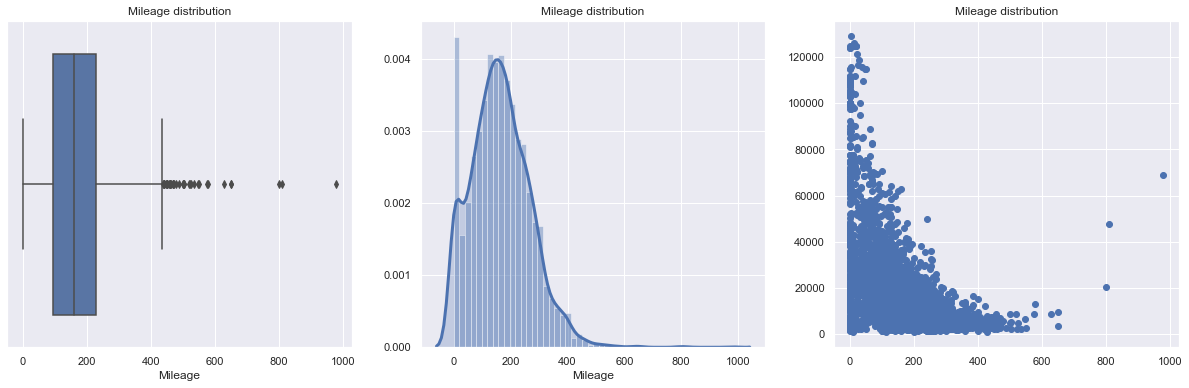

In [20]:
analyse_continuous(data_1,'Mileage',target_var,'Mileage'+' distribution')

The data is still distributed in the same way but with less outliers. We can deal with it in the same way keeping only the data lower than the ninety ninth percentile

In [21]:
q = data_1['Mileage'].quantile(0.99)
data_2 = data_1[data_1['Mileage']<q]
data_2.reset_index(drop=True,inplace=True)

Skewness: 0.265109
Kurtosis: -0.426539


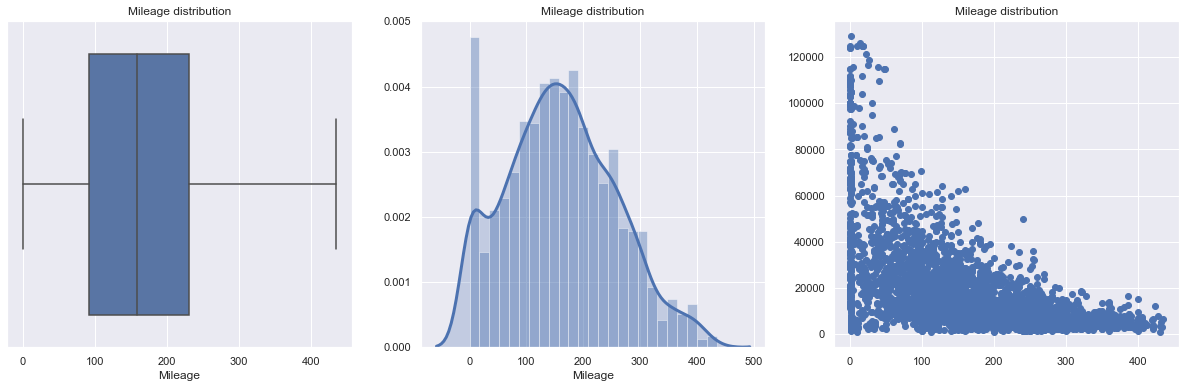

In [22]:
analyse_continuous(data_2,'Mileage',target_var,'Mileage'+' distribution')

In [23]:
target = data_2['Price']
num_df = data_2[num_vars]

Predictive_Model(num_df, cat_df, target)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 20)                80        
_________________________________________________________________
dense_19 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
Train on 2524 samples, validate on 631 samples
Epoch 1/100
2524/2524 [==============================] - 0s 179us/sample - loss: 707517080.7734 - mse: 707517120.0000 - mae: 18271.0684 - val_loss: 566924238.4025 - val_mse: 566924288.0000 - val_mae: 16993.6289
Epoch 2/100
2524/2524 [==============================] - 0s 37us/sample - loss: 707493653.5784 - mse: 707493760.0000 - mae: 1827

2524/2524 [==============================] - 0s 35us/sample - loss: 559522033.4200 - mse: 559521920.0000 - mae: 15628.7734 - val_loss: 433749995.5119 - val_mse: 433749952.0000 - val_mae: 14251.2793
Epoch 37/100
2524/2524 [==============================] - 0s 35us/sample - loss: 549757227.9303 - mse: 549757120.0000 - mae: 15438.6035 - val_loss: 425087914.4469 - val_mse: 425087904.0000 - val_mae: 14055.5693
Epoch 38/100
2524/2524 [==============================] - 0s 35us/sample - loss: 539817346.0285 - mse: 539817408.0000 - mae: 15242.5859 - val_loss: 416457601.7242 - val_mse: 416457600.0000 - val_mae: 13858.3516
Epoch 39/100
2524/2524 [==============================] - 0s 37us/sample - loss: 529784989.9461 - mse: 529785088.0000 - mae: 15044.9053 - val_loss: 407783386.8273 - val_mse: 407783392.0000 - val_mae: 13656.8857
Epoch 40/100
2524/2524 [==============================] - 0s 34us/sample - loss: 519523285.9842 - mse: 519523296.0000 - mae: 14842.5420 - val_loss: 399068337.3946 - val_

Epoch 75/100
2524/2524 [==============================] - 0s 35us/sample - loss: 236865565.2361 - mse: 236865536.0000 - mae: 9917.9170 - val_loss: 175580370.9414 - val_mse: 175580368.0000 - val_mae: 9029.8125
Epoch 76/100
2524/2524 [==============================] - 0s 34us/sample - loss: 233810314.9477 - mse: 233810272.0000 - mae: 9902.7432 - val_loss: 174057102.8082 - val_mse: 174057088.0000 - val_mae: 9028.2900
Epoch 77/100
2524/2524 [==============================] - 0s 35us/sample - loss: 231222995.3724 - mse: 231222976.0000 - mae: 9893.2500 - val_loss: 172699696.4057 - val_mse: 172699680.0000 - val_mae: 9032.5947
Epoch 78/100
2524/2524 [==============================] - 0s 35us/sample - loss: 228871930.7765 - mse: 228871984.0000 - mae: 9894.0518 - val_loss: 171523832.0380 - val_mse: 171523808.0000 - val_mae: 9040.9209
Epoch 79/100
2524/2524 [==============================] - 0s 36us/sample - loss: 226715546.2884 - mse: 226715536.0000 - mae: 9892.2373 - val_loss: 170626764.2472 - 

### EngineV

Skewness: 17.051901
Kurtosis: 311.502019


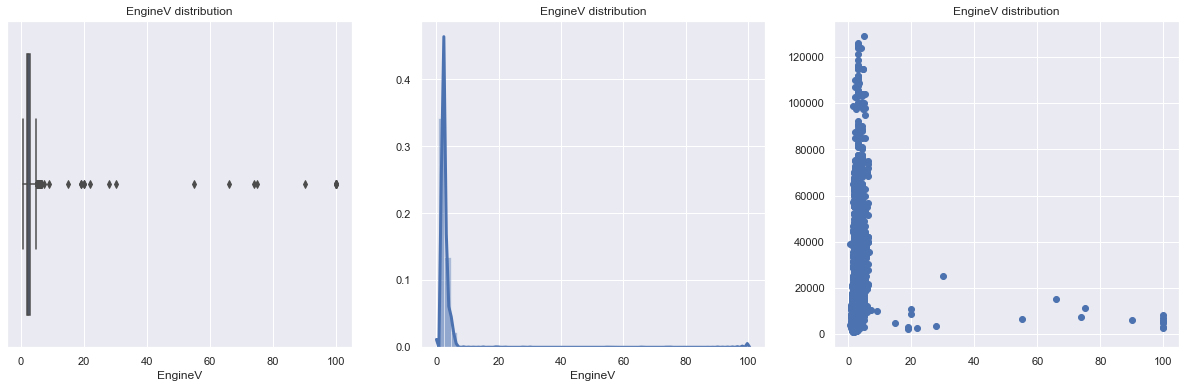

In [19]:
analyse_continuous(data_2,'EngineV',target_var,'EngineV'+' distribution')

In [20]:
# A simple Google search can indicate the natural domain of this variable
# Car engine volumes are usually (always?) below 6.5l
# This is a prime example of the fact that a domain expert (a person working in the car industry)
# may find it much easier to determine problems with the data than an outsider
data_3 = data_2[data_2['EngineV']<6.5]
data_3.reset_index(drop=True,inplace=True)

Skewness: 1.490153
Kurtosis: 2.342794


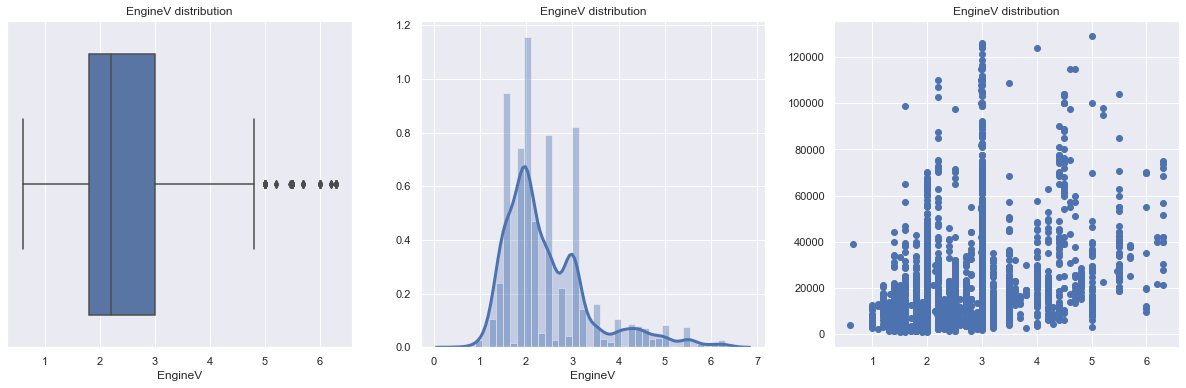

In [21]:
analyse_continuous(data_3,'EngineV',target_var,'EngineV'+' distribution')

Following this graph, we realize we can actually treat EngineV as a categorical variable. Even so, in this course we won't, but that's yet something else you may try on your own

In [22]:
target = data_3['Price']
num_df = data_3[num_vars]

Predictive_Model(num_df, cat_df, target)

Train set:  0.950894984129949
Test set:  0.8530333579852121
Year                                               Importance: 0.53
EngineV                                            Importance: 0.34
Mileage                                            Importance: 0.13


### Year

Skewness: -0.977779
Kurtosis: 1.077789


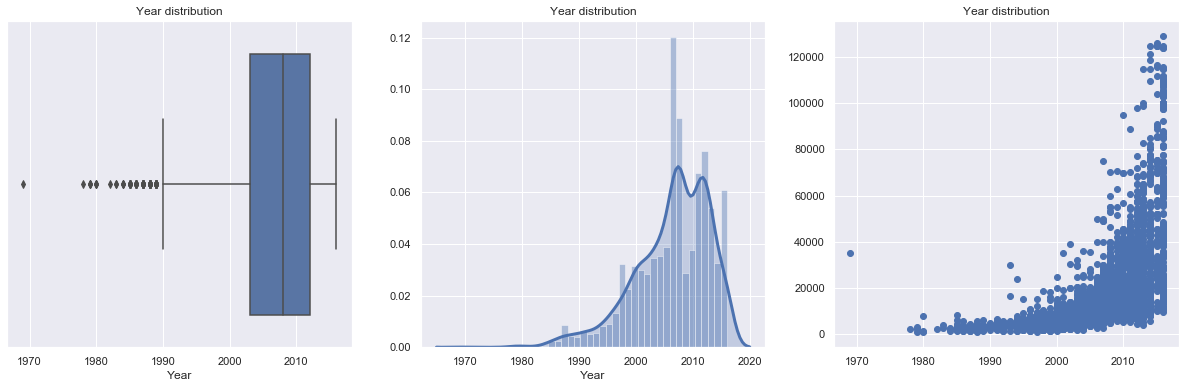

In [23]:
analyse_continuous(data_3,'Year',target_var,'Year'+' distribution')

The problem with year is it's on the low end. Most cars are newer but there seem to be a few vintage cars this time. This time, I'll take the first percentile and the we'll keep all observations that are higher

In [24]:
# I'll simply remove them
q = data_3['Year'].quantile(0.01)
data_4 = data_3[data_3['Year']>q]
data_4.reset_index(drop=True,inplace=True)

Skewness: -0.718794
Kurtosis: 0.109411


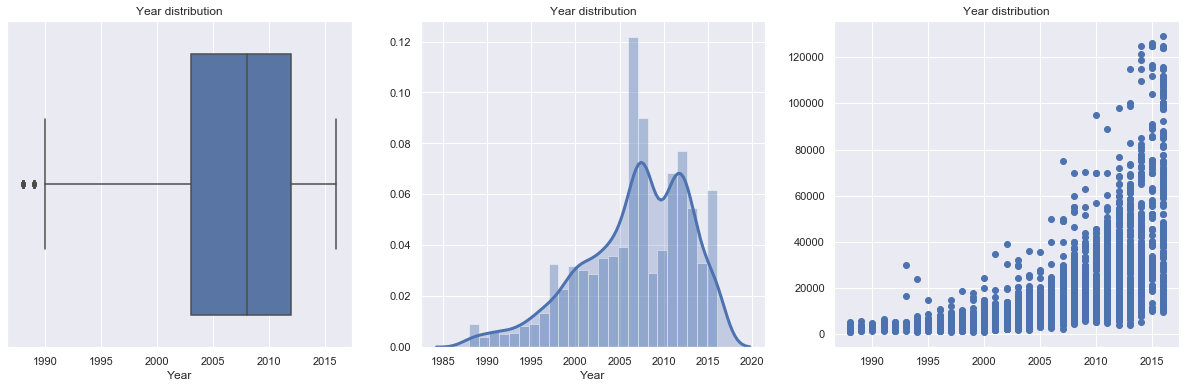

In [25]:
analyse_continuous(data_4,'Year',target_var,'Year'+' distribution')

In [26]:
target = data_4['Price']
num_df = data_4[num_vars]

Predictive_Model(num_df, cat_df, target)

Train set:  0.9533456439831323
Test set:  0.8380838383018269
Year                                               Importance: 0.53
EngineV                                            Importance: 0.35
Mileage                                            Importance: 0.13


### Data cleaned

In [27]:
# When we remove observations, the original indexes are preserved
# If we remove observations with indexes 2 and 3, the indexes will go as: 0,1,4,5,6
# That's very problematic as we tend to forget about it (later you will see an example of such a problem)

# Finally, once we reset the index, a new column will be created containing the old index (just in case)
# We won't be needing it, thus 'drop=True' to completely forget about it
data_cleaned = data_4.reset_index(drop=True)

In [28]:
# Let's see what's left
data_cleaned.describe(include='all')

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
count,3867,3867.000000,3867,3867.000000,3867.000000,3867,3867,3867.000000,3867
unique,7,NaN,6,NaN,NaN,4,2,NaN,291
top,Volkswagen,NaN,sedan,NaN,NaN,Diesel,yes,NaN,E-Class
freq,848,NaN,1467,NaN,NaN,1807,3505,NaN,181
mean,NaN,18194.455679,NaN,160.542539,2.450440,NaN,NaN,2006.709853,NaN
std,NaN,19085.855165,NaN,95.633291,0.949366,NaN,NaN,6.103870,NaN
min,NaN,800.000000,NaN,0.000000,0.600000,NaN,NaN,1988.000000,NaN
25%,NaN,7200.000000,NaN,91.000000,1.800000,NaN,NaN,2003.000000,NaN
50%,NaN,11700.000000,NaN,157.000000,2.200000,NaN,NaN,2008.000000,NaN
75%,NaN,21700.000000,NaN,225.000000,3.000000,NaN,NaN,2012.000000,NaN


## 6.2. Checking and fixing the assumptions in linear relationship

### 6.2.1. Checking linear relationship between independent and dependent variables

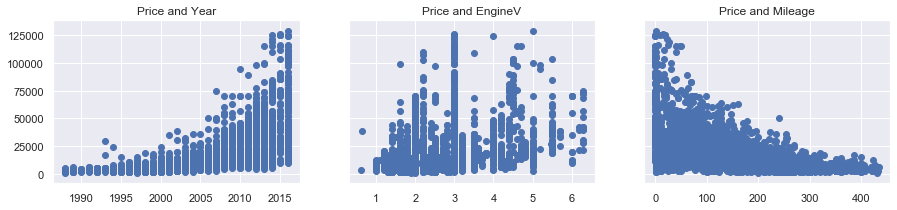

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned['Year'], data_cleaned['Price'])
ax1.set_title('Price and Year')
ax2.scatter(data_cleaned['EngineV'], data_cleaned['Price'])
ax2.set_title('Price and EngineV')
ax3.scatter(data_cleaned['Mileage'], data_cleaned['Price'])
ax3.set_title('Price and Mileage')

plt.show()

We can spot patterns but definitely not linear ones. We know we should not run a linear regression in this case. We should first transform one or more variables 

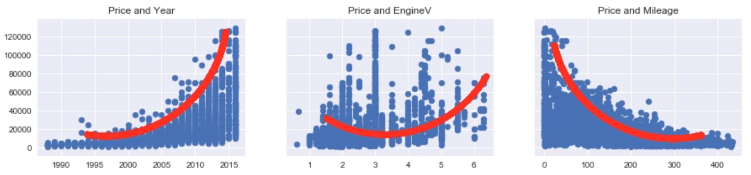

Recall the distribution plot of price to all these plot of price to all these plots are pointing us towards the idea that price is not normally distributed. And from there it's relationships with other rather normally distributed features is not linear. The patterns are quite exponential.

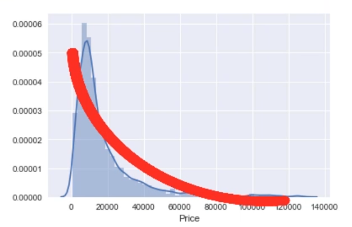

#### Log transformation

Log transformation is a common way to deal with this issue. It is especially useful when facing exponential relationships. 

In [30]:
log_price = np.log(data_cleaned['Price'])
data_cleaned['log_price'] = log_price
data_cleaned.head()

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model,log_price
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320,8.342840
1,Mercedes-Benz,7900.0,van,427,2.9,Diesel,yes,1999,Sprinter 212,8.974618
2,Mercedes-Benz,13300.0,sedan,358,5.0,Gas,yes,2003,S 500,9.495519
3,Audi,23000.0,crossover,240,4.2,Petrol,yes,2007,Q7,10.043249
4,Toyota,18300.0,crossover,120,2.0,Petrol,yes,2011,Rav 4,9.814656


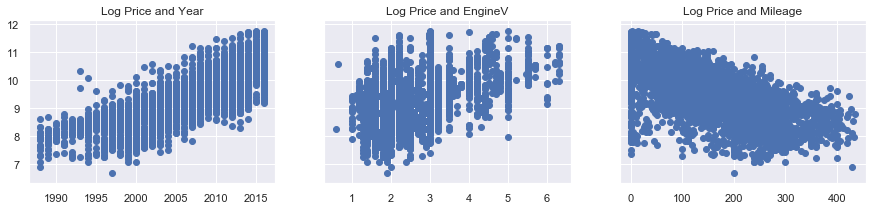

In [31]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,3))
ax1.scatter(data_cleaned['Year'], data_cleaned['log_price'])
ax1.set_title('Log Price and Year')
ax2.scatter(data_cleaned['EngineV'], data_cleaned['log_price'])
ax2.set_title('Log Price and EngineV')
ax3.scatter(data_cleaned['Mileage'], data_cleaned['log_price'])
ax3.set_title('Log Price and Mileage')

plt.show()

We can see a linear pattern in all plots now. The lines fit the data so much better

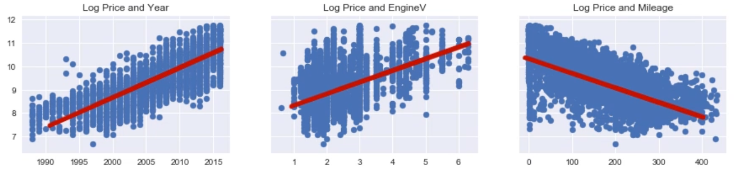

[]

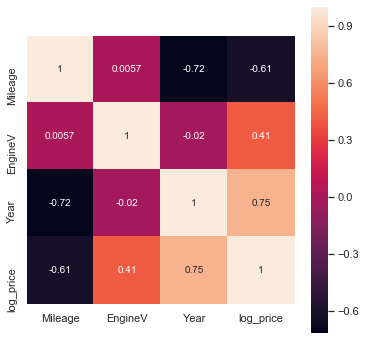

In [32]:
target_var = 'log_price'
corr = data_cleaned[num_vars + [target_var]].corr()
plt.figure(figsize = (6,6))
sns.heatmap(data = corr, annot = True, square = True, cbar = True)
plt.plot()

In [41]:
target = log_price
cat_df = pd.DataFrame()
num_df = data_cleaned[num_vars]

Predictive_Model(num_df, cat_df, target)

Train set:  0.96339133414485
Test set:  0.8156431569301349
Year                                               Importance: 0.58
EngineV                                            Importance: 0.27
Mileage                                            Importance: 0.15


In [42]:
target = data_cleaned[['Price']]
num_df = data_cleaned[num_vars]
cat_df = pd.DataFrame()

Predictive_Model(num_df, cat_df, target)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set:  0.9531121357741105
Test set:  0.8360516079315008
Year                                               Importance: 0.53
EngineV                                            Importance: 0.35
Mileage                                            Importance: 0.13


## 6.3. Create dummy variables

### All

If we have N categories for a feature, we have to create N-1 dummies. 

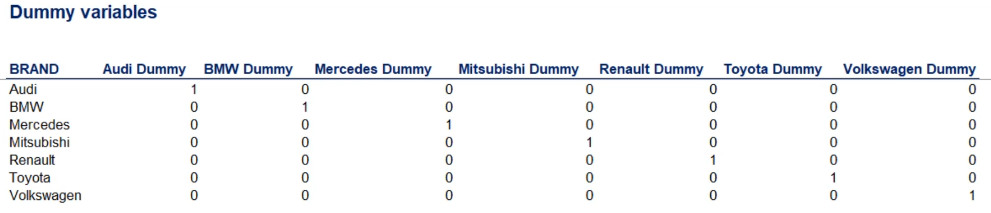

For the first brand we will not create a dummy variable. The reason is if all other dummy variables are zeros, it's clear that the car is an Audi. If we include a separate variable called Audi we will introduce multicolinearity to the regression as the Audi dummy would be perfectly determined by the other variables. Thus if we have n categories there will only be N minus one dummies 

In [43]:
cat_vars = [var for var in data.columns if data[var].dtypes == 'O']
cat_vars

['Brand', 'Body', 'Engine Type', 'Registration', 'Model']

#### Removing the first dummy

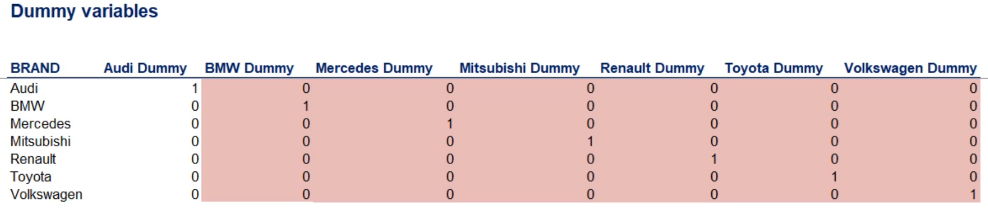

In [44]:
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
cat_df.head()

,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,...,Model_Vito,Model_X1,Model_X3,Model_X5,Model_X5 M,Model_X6,Model_X6 M,Model_Yaris,Model_Z3,Model_Z4
0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
cat_df.shape

(3867, 305)

In [46]:
target = data_cleaned[['Price']]
num_df = data_cleaned[num_vars]

Predictive_Model(num_df, cat_df, target)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set:  0.9896905696217353
Test set:  0.9391889328054424
Year                                               Importance: 0.49
EngineV                                            Importance: 0.3
Mileage                                            Importance: 0.06
Brand_Mercedes-Benz                                Importance: 0.03
Brand_BMW                                          Importance: 0.01
Body_sedan                                         Importance: 0.01
Registration_yes                                   Importance: 0.01
Model_Multivan                                     Importance: 0.01
Model_V 250                                        Importance: 0.01
Model_X5                                           Importance: 0.01
Brand_Mitsubishi                                   Importance: 0.0
Brand_Renault                                      Importance: 0.0
Brand_Toyota                                       Importance: 0.0
Brand_Volkswagen                                   Importan

### Brand

In [47]:
cat_vars = ['Brand']
cat_df = pd.get_dummies(data_cleaned[cat_vars])
Predictive_Model(num_df, cat_df, target)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set:  0.9777410056583788
Test set:  0.9045483280137158
Year                                               Importance: 0.5
EngineV                                            Importance: 0.32
Mileage                                            Importance: 0.09
Brand_Mercedes-Benz                                Importance: 0.04
Brand_BMW                                          Importance: 0.02
Brand_Audi                                         Importance: 0.01
Brand_Toyota                                       Importance: 0.01
Brand_Mitsubishi                                   Importance: 0.0
Brand_Renault                                      Importance: 0.0
Brand_Volkswagen                                   Importance: 0.0


In [48]:
cat_vars = ['Brand']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set:  0.9780586120452777
Test set:  0.901185831618165
Year                                               Importance: 0.51
EngineV                                            Importance: 0.32
Mileage                                            Importance: 0.09
Brand_Mercedes-Benz                                Importance: 0.04
Brand_BMW                                          Importance: 0.02
Brand_Toyota                                       Importance: 0.01
Brand_Mitsubishi                                   Importance: 0.0
Brand_Renault                                      Importance: 0.0
Brand_Volkswagen                                   Importance: 0.0


### Body

In [49]:
cat_vars = ['Body']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set:  0.9631766736417435
Test set:  0.8685621567854296
Year                                               Importance: 0.53
EngineV                                            Importance: 0.34
Mileage                                            Importance: 0.1
Body_sedan                                         Importance: 0.02
Body_other                                         Importance: 0.01
Body_van                                           Importance: 0.01
Body_hatch                                         Importance: 0.0
Body_vagon                                         Importance: 0.0


### Engine Type

In [50]:
cat_vars = ['Engine Type']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set:  0.959770484445927
Test set:  0.8493223421078302
Year                                               Importance: 0.52
EngineV                                            Importance: 0.34
Mileage                                            Importance: 0.12
Engine Type_Petrol                                 Importance: 0.01
Engine Type_Gas                                    Importance: 0.0
Engine Type_Other                                  Importance: 0.0


### Registration

In [51]:
cat_vars = ['Registration']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set:  0.9548048319386387
Test set:  0.8364546073143296
Year                                               Importance: 0.53
EngineV                                            Importance: 0.34
Mileage                                            Importance: 0.12
Registration_yes                                   Importance: 0.01


### Model

In [52]:
cat_vars = ['Model']
cat_df = pd.get_dummies(data_cleaned[cat_vars], drop_first=True)
Predictive_Model(num_df, cat_df, target)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Train set:  0.9876332831820572
Test set:  0.9291059461116629
Year                                               Importance: 0.5
EngineV                                            Importance: 0.31
Mileage                                            Importance: 0.06
Model_Multivan                                     Importance: 0.01
Model_S 350                                        Importance: 0.01
Model_V 250                                        Importance: 0.01
Model_Viano                                        Importance: 0.01
Model_X5                                           Importance: 0.01
Model_100                                          Importance: 0.0
Model_11                                           Importance: 0.0
Model_116                                          Importance: 0.0
Model_118                                          Importance: 0.0
Model_120                                          Importance: 0.0
Model_19                                           Importance

# Random Forest after preprocessing data

### Declare the inputs and the targets

In [53]:
data_cleaned.columns

Index(['Brand', 'Price', 'Body', 'Mileage', 'EngineV', 'Engine Type',
       'Registration', 'Year', 'Model', 'log_price'],
      dtype='object')

In [54]:
num_df = data_cleaned[['Mileage','EngineV','Year']]
cat_df = data_cleaned[['Brand','Body','Engine Type','Registration']]

### Scale numerical features

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(num_df)
scaled_df = scaler.transform(num_df)
scaled_df = pd.DataFrame(scaled_df, columns = num_df.columns)
scaled_df.head()

,Mileage,EngineV,Year
0,1.217908,-0.474525,-2.574086
1,2.786602,0.473599,-1.263272
2,2.065003,2.685886,-0.607866
3,0.830963,1.843110,0.047541
4,-0.423992,-0.474525,0.702948


### create dummy vars for categorical features

In [56]:
dummy_df = pd.get_dummies(cat_df, drop_first=True)
dummy_df.head()

,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes
0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1
1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1


Note: it is not usually recommended to standardize dummy variables. In fact, many practitioners would argue strongly agains it

### Create preprocessed data

In [72]:
input_df = pd.concat([scaled_df,dummy_df],axis=1)
target = data_cleaned[['log_price']]

data_preprocessed = pd.concat([input_df,target],axis=1)
print(data_preprocessed.shape)
data_preprocessed.head()

(3867, 19)


,Mileage,EngineV,Year,Brand_BMW,Brand_Mercedes-Benz,Brand_Mitsubishi,Brand_Renault,Brand_Toyota,Brand_Volkswagen,Body_hatch,Body_other,Body_sedan,Body_vagon,Body_van,Engine Type_Gas,Engine Type_Other,Engine Type_Petrol,Registration_yes,log_price
0,1.217908,-0.474525,-2.574086,1,0,0,0,0,0,0,0,1,0,0,0,0,1,1,8.342840
1,2.786602,0.473599,-1.263272,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,8.974618
2,2.065003,2.685886,-0.607866,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,9.495519
3,0.830963,1.843110,0.047541,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,10.043249
4,-0.423992,-0.474525,0.702948,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,9.814656


### Train Test Split

In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_df, target, test_size=0.2, random_state=365)

### Using sklearn

In [74]:
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X_train, y_train)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [75]:
y_hat = model.predict(X_train)

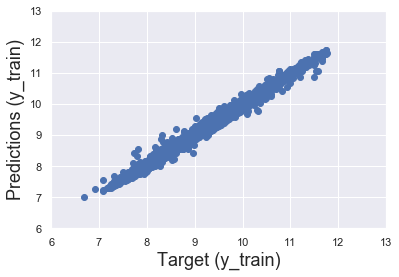

In [76]:
plt.scatter(y_train, y_hat)
plt.xlabel('Target (y_train)', size = 18)
plt.ylabel('Predictions (y_train)', size = 18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

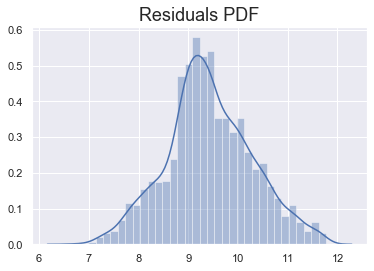

In [77]:
residuals = y_train['log_price'].values - y_hat
sns.distplot(y_train.values)
plt.title("Residuals PDF", size = 18)
plt.show()

In [78]:
model.score(X_train, y_train)

0.9878455730495191

In [79]:
model.score(X_test, y_test)

0.9195196722998881

In [80]:
    # Get numerical feature importance
    feature_importance = list(model.feature_importances_)
    feature_labels = X_train.columns
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_labels, feature_importance)]
    # Sort the feature importance by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importance 
    [print('{:50} Importance: {}'.format(*pair)) for pair in feature_importances];

Year                                               Importance: 0.57318
EngineV                                            Importance: 0.21659
Mileage                                            Importance: 0.07191
Registration_yes                                   Importance: 0.06996
Brand_Renault                                      Importance: 0.01133
Brand_Mercedes-Benz                                Importance: 0.00808
Body_van                                           Importance: 0.00732
Body_sedan                                         Importance: 0.00621
Brand_BMW                                          Importance: 0.00592
Brand_Mitsubishi                                   Importance: 0.00584
Brand_Volkswagen                                   Importance: 0.00482
Brand_Toyota                                       Importance: 0.00468
Engine Type_Petrol                                 Importance: 0.00366
Body_other                                         Importance: 0.00313
Body_v

### Testing

In [81]:
y_hat_test = model.predict(X_test)

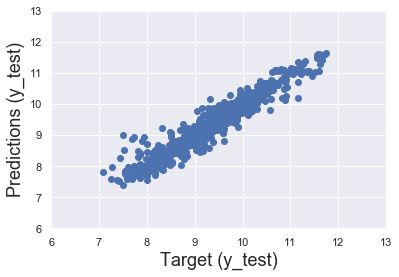

In [82]:
plt.scatter(y_test, y_hat_test)
plt.xlabel('Target (y_test)', size = 18)
plt.ylabel('Predictions (y_test)', size = 18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

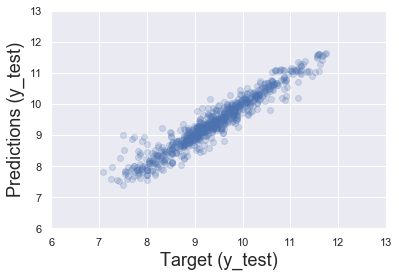

In [83]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Target (y_test)', size = 18)
plt.ylabel('Predictions (y_test)', size = 18)
plt.xlim(6,13)
plt.ylim(6,13)
plt.show()

In [84]:
model.score(X_test, y_test)

0.9195196722998881

In [85]:
df_pf = pd.DataFrame(y_hat_test, columns=['Prediction'])
df_pf.head()

,Prediction
0,8.945284
1,8.006368
2,7.703304
3,8.733748
4,9.087067


In [86]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,7671.628508
1,3000.002355
2,2215.656781
3,6208.955364
4,8840.217175


In [87]:
df_pf['Target'] = np.exp(y_test)
df_pf.head()

,Prediction,Target
0,7671.628508,NaN
1,3000.002355,7900.0
2,2215.656781,NaN
3,6208.955364,NaN
4,8840.217175,NaN


In [88]:
y_test.head()

,log_price
1192,7.740664
3360,7.937375
2350,7.824046
3257,8.764053
892,9.121509


In [89]:
y_test = y_test.reset_index(drop = True)
y_test.head()

,log_price
0,7.740664
1,7.937375
2,7.824046
3,8.764053
4,9.121509


In [90]:
df_pf['Target'] = np.exp(y_test)
df_pf.head()

,Prediction,Target
0,7671.628508,2300.0
1,3000.002355,2800.0
2,2215.656781,2500.0
3,6208.955364,6400.0
4,8840.217175,9150.0


In [91]:
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target'] * 100)
df_pf.head()

,Prediction,Target,Residual,Difference%
0,7671.628508,2300.0,-5371.628508,233.549066
1,3000.002355,2800.0,-200.002355,7.142941
2,2215.656781,2500.0,284.343219,11.373729
3,6208.955364,6400.0,191.044636,2.985072
4,8840.217175,9150.0,309.782825,3.385605


In [92]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,774.000000,774.000000,774.000000,774.000000
mean,17692.368199,18165.817106,473.448907,18.798172
std,18501.400582,19967.858908,5810.997342,25.640177
min,1605.675602,1200.000000,-22581.744020,0.016842
25%,6785.637904,6900.000000,-1218.934566,5.033641
50%,11147.857852,11600.000000,50.831745,12.249840
75%,20973.212685,20500.000000,1417.799823,23.949399
max,114613.881634,126000.000000,45839.859692,350.883387


In [93]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_pf.sort_values(by=['Difference%'])

,Prediction,Target,Residual,Difference%
405,9401.58,9400.00,-1.58,0.02
224,15502.72,15500.00,-2.72,0.02
749,7447.32,7450.00,2.68,0.04
226,9604.34,9600.00,-4.34,0.05
632,15002.34,14990.00,-12.34,0.08
218,14916.03,14900.00,-16.03,0.11
560,40749.14,40800.00,50.86,0.12
188,10885.57,10900.00,14.43,0.13
90,6810.06,6800.00,-10.06,0.15
227,14321.94,14300.00,-21.94,0.15


## Tuning model